# Delft3D IO Module

The following example will familiarize the user with using the Delft3D (d3d) toolbox in MHKiT-Python. `d3d` can be used to plot the data from a NetCDF output from Delft3D [SNL-D3D-CEC-FM](https://github.com/MHKiT-Software/MHKiT-Python). The example will walk through a flume case with a turbine. The flume is 18 m long, 4 m wide and 2m deep with the turbine placed at 6 m along the length and 3 m along the width. The turbine used for this simulation has a circular cross-section with a diameter of 0.7m, a thrust coefficient of 0.72, and a power coefficient of 0.45. The simulation was run with 5 depth layers and 5-time intervals over 4 min.

This example will show how to create a centerline plot at a desired depth for different variables outputs of Delft3D using matplotlib. It will also show how to make a contour plot of a given plane or depth for the variable output by Delft3D and how to use those variables to calculate turbulence intensity. This module can be helpful to visualize the wake of a turbine and help predict how a turbine will affect the surrounding area. 

Start by importing the necessary python packages and MHKiT module.  

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
from math import isclose
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4
plt.rcParams.update({'font.size': 15}) # Set font size of plots title and labels 

## Loading Data from Delft3D as a NetCDF 

 A NetCDF file has been saved in the [\\MHKiT-Python\\examples\\data\\river\\d3d](https://github.com/browniea/MHKiT-Python/tree/d3d/examples/data/river/d3d) directory of a simple flume case with a turbine for reference data. Here we are inputting strings for the file path `datadir`, and file name `filename`, so the NetCDF file can be saved as a NetCDF object using the python pack `netCDF4` under the variable `d3d_data`.    
 
There are many variables saved in the NetCDF object `d3d_data`. The function `d3d_data.variables.keys()` returns a dictionary of the available data. Here we look at the dictionary keys output to see all the variables. 

In [2]:
# Downloading Data
datadir = normpath(join(relpath(join('data', 'river', 'd3d'))))
filename= 'turbineTest_map.nc'
d3d_data = netCDF4.Dataset(join(datadir,filename)) 

# Printing variable and description
for var in d3d_data.variables.keys():
    try: 
        d3d_data[var].long_name
    except:
        print(f'"{var}"')        
    else:
        print(f'"{var}": {d3d_data[var].long_name}')

"mesh2d_enc_x": x-coordinate
"mesh2d_enc_y": y-coordinate
"mesh2d_enc_node_count": count of coordinates in each instance geometry
"mesh2d_enc_part_node_count": count of nodes in each geometry part
"mesh2d_enc_interior_ring": type of each geometry part
"mesh2d_enclosure_container"
"Mesh2D"
"NetNode_x": x-coordinate
"NetNode_y": y-coordinate
"projected_coordinate_system"
"NetNode_z": bed level at net nodes (flow element corners)
"NetLink": link between two netnodes
"NetLinkType": type of netlink
"NetElemNode": mapping from net cell to net nodes (counterclockwise)
"NetElemLink": mapping from net cell to its net links (counterclockwise)
"NetLinkContour_x": list of x-contour points of momentum control volume surrounding each net/flow link
"NetLinkContour_y": list of y-contour points of momentum control volume surrounding each net/flow link
"NetLink_xu": x-coordinate of net link center (velocity point)
"NetLink_yu": y-coordinate of net link center (velocity point)
"BndLink": netlinks that co

## Seconds Run and Time Index

The `'time_index;` can be used to pull data from different instances in time. The first index is 0 and the last is 4, in this example, since there are 5-time steps. Each time_index has an associated `'seconds_run'` that quantifies the number of seconds that has passed from the start of the simulation. To get all of the `'seconds_run'` for a data set use the function `get_all_time` the output is an array of all the `'seconds_run'` for the input data set.  

In [3]:
time= d3d.get_all_time(d3d_data)
print(time)

[  0.  60. 120. 180. 240.]


To convert from a `'seconds_run'` to a `'time_index'` or vice versa. The inputs are a netcdf data set, then a `'time_index'`. This example shows what happens if you input a `'seconds_run'` that is close to but not exactly a `'seconds_run'` associated with a `'time_idex'`.

In [4]:
seconds_run = 62
time_index=d3d.convert_time(d3d_data,seconds_run=seconds_run)
print(time_index)

1


<ipython-input-4-b36b9e0df502>:2: UserWarning: Warning: seconds_run not found. Closest time stampfound {times[idx]}
  time_index=d3d.convert_time(d3d_data,seconds_run=seconds_run)


## Dataframe from NetCDF
First the variable to be pulled from the NetCDF file are defined and saved under the name `variable`. For this example we will use the variable `'ucx'`, the velocity in the x-direction (see available data in previous block output). The `d3d` function `get_all_data_points` will pull all the raw data from the NetCDF file for the specified variable at a specific time index in a dataframe `var_data_df`. The `time_index` can be used to pull data from a different instances in time. The first index is 0 and the last is 4 since there are 5-time steps. The user can also use -1 to select the last valid time_index in the data set, this is the default setting. If an integer outside of the valid range is entered the code will output an error with the max valid output listed.  The output data from  `get_all_data_points` will be the position (x, y, z) in meters, the value of vairable in meters per second and the run time of the simulation in seconds or `'x'`, `'y'`, `'z'`, '`ucx`', and `'time'`. The time run in simulation varies based on the 'time_step'. 

The limits `max_plot_v` and `min_plot_v` are defined to bound the plots of the variable's data in the next 3 examples.

In [5]:
# Getting variable data 
variable= 'ucx' 
var_data_df= d3d.get_all_data_points(d3d_data, variable, time_index=4)
print(var_data_df)

# Setting plot limits 
max_plot_v= 1.25
min_plot_v=0.5

           x      y         z       ucx   time
0      0.125  1.125  0.204638  0.717881  240.0
1      0.375  1.125  0.199927  0.689645  240.0
2      0.125  1.375  0.204638  0.717881  240.0
3      0.625  1.125  0.199497  0.694164  240.0
4      0.375  1.375  0.199927  0.689645  240.0
...      ...    ...       ...       ...    ...
5755  17.625  4.625  1.800595  1.245117  240.0
5756  17.375  4.875  1.800572  1.222989  240.0
5757  17.875  4.625  1.800020  1.255866  240.0
5758  17.625  4.875  1.800596  1.245292  240.0
5759  17.875  4.875  1.800019  1.256067  240.0

[5760 rows x 5 columns]


## Plotting a Line Plot Between Two Points 
To view the maximum wake effect of the turbine we can plot a velocity down the centerline of the flume. To do this we will create an array between two points down the center of the flume. We will then interpolate the grided data results onto our centerline array. Since the flume is retangular the centerline points are found by taking the average of the maximum and minimum value for the width, `y`, and height, `z`, of the flume. We will then input one array, `x`, and two points, `y` and `z` into the function `create_points` to create our centerline array to interpolate over. The function `create_points` will then output a dataframe, `cline_points`, with keys `'x'`, `'y'`, and `'z'`.

In [6]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()

# Creating one array and 2 points 
x = np.linspace(xmin, xmax, num=100)
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

# Creating an array of points  
cline_points = d3d.create_points(x, y, z)
cline_points

0


,x,y,z
0,17.875000,3.0,0.999069
1,17.695707,3.0,0.999069
2,17.516414,3.0,0.999069
3,17.337121,3.0,0.999069
4,17.157828,3.0,0.999069
...,...,...,...
95,0.842172,3.0,0.999069
96,0.662879,3.0,0.999069
97,0.483586,3.0,0.999069
98,0.304293,3.0,0.999069


Next the variable `ucx` is interpolated over the `cline_points` using scipy interp function and saved as `cline_variable`. The results are then plotted for velocity in the x direction, `ucx`, along the length of the flume, `x`.

Text(0.5, 1.0, 'Centerline Velocity On Flow Element Center, X-component \n  time: 240.0 s')

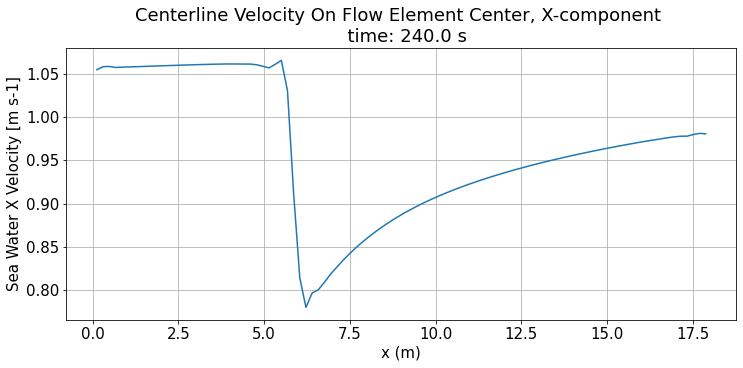

In [7]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']]) 
# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
plt.plot(x, cline_variable)
plt.grid()
plt.xlabel('x (m)')

y_name= f'{d3d_data.variables[variable].standard_name}'
y_label=' '.join([x.capitalize() for x in y_name.split('_')])
plt.ylabel(f'{y_label} [{d3d_data.variables[variable].units}]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  time: {var_data_df.time[1]} s')

## Contour Plot for a Given Sigma Layer 

Sometimes it will be useful to plot only the raw data of a given layer. Using `get_layer_data` a single layer of raw data will be retrieved from the NetCDF object. The `d3d` function ,`get_layer_data` takes 3 inputs, the NetCDF object (`d3d_data`), a variable name as a string (`variable`), and the layer to retrieve (`layer`) as an integer. The variable is set to the velocity in the x direction, `'ucx'`, and the layer of data to plot as 2. Since there are 5 sigma layers in this example layer 2 is approximately the middle layer.  `layer` works as an index that begins at begins at 0 and ends at 4.  The `get_layer_data` then outputs a dataframe `layer_data` with the keys `'x'`, `'y'`, `z`, '`v`', and `'time'` as the length, width, depth, value, and run time of simulation of the specified variable in this case velocity in the x direction, 'ucx'.  

To plot the data the maximum and minimum, `max_plot_v` and `min_plot_v`, values are pulled from above to limit bounds of the color bar to show the value of the specified variable, in this case it's velocity in the x direction. The type of plot is also defined as a string 'contour' to add to the title of the plot.

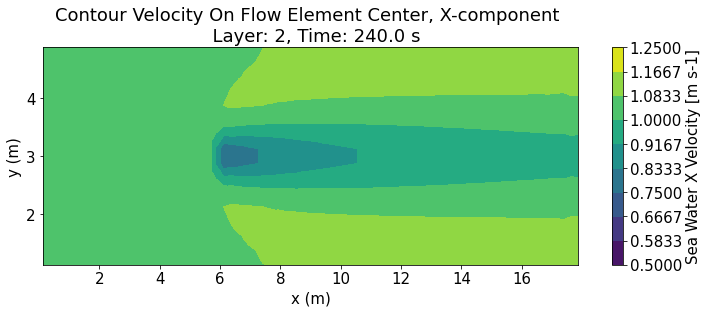

In [8]:
layer= 2
layer_data = d3d.get_layer_data(d3d_data, variable, layer)

# Plotting 
Type= 'Contour'
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(layer_data.x ,layer_data.y, layer_data.v, vmin=min_plot_v,vmax=max_plot_v,
                            levels=np.linspace(min_plot_v,max_plot_v,10))
    
plt.xlabel('x (m)')
plt.ylabel('y (m)')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  Layer: {layer}, Time: {layer_data.time[1]} s')


cbar= plt.colorbar(contour_plot)
cbar_name= f'{d3d_data.variables[variable].standard_name}'
cbar_label=' '.join([x.capitalize() for x in cbar_name.split('_')])
cbar.set_label(f'{cbar_label} [{d3d_data.variables[variable].units}]')

## Plotting a Contour Plot of a given Plane 

If you wanted to look at a contour plot of a specific depth you can create a contour plot over given points. Expanding on the centerline array points we can create a grid using the same `create_points` function by inputting two arrays along the length of the flume, `x`  , and width of the flume, `y_contour` , and one point for the depth we want to look at `z`.  `create_points` then outputs a dataframe `contour_points` of points to calculate the contour values over with the keys `'x'`, `'y'`, and `'z'`.

In [9]:
x = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z = np.mean([zmin,zmax])

contour_points = d3d.create_points(x, y_contour, z) 

[0, 1, 2]


Next the data is interpolated on to the points created and saved as an arrray under the variable name `contour_variable`. 

In [10]:
contour_variable = interp.griddata(var_data_df[['x','y','z']], 
                                                     var_data_df[variable],
                                                     contour_points[['x','y','z']])

The results are then plotted. The minimum and maximum values show on the graph are pulled from above (`max_plot_v` and `min_plot_v`) as in the previous example. The contour plot of the velocity is then output at the center depth of the flume. 

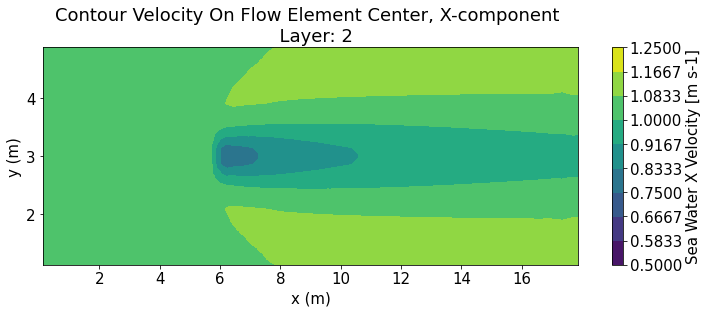

In [11]:
# Plotting 
Type= 'Contour'
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_variable,
                               vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))

plt.xlabel('x (m)')
plt.ylabel('y (m)')
title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  Layer: {layer}')

cbar= plt.colorbar(contour_plot)
cbar_name= f'{d3d_data.variables[variable].standard_name}'
cbar_label=' '.join([x.capitalize() for x in cbar_name.split('_')])
cbar.set_label(f'{cbar_label} [{d3d_data.variables[variable].units}]')

## Contour Plot of Turbulent Intensity 

Turbulent Intensity is the ratio of the magnitude of turbulent velocity to total velocity. The function `turbulent_intensity` takes the inputs of the NetCDF object, the points to caculate  over, the time index, and an optional boolian input to output `intermediate_values` used to calculate turbulent intensity. The fuction then pulls variables `'ucx'`, `'ucy'`, `'ucz'`, and `'turkin1'` as the velocity in the x, y, z and turbulence kinetic energy respectively. The function then calculates and outputs the turbulent intensity, `turbulent_intensity`, for any given time_index in the data_frame `TI`. The `TI` dataframe also includes the `x`,`y`, and `z` location. If the `intermediate_values` bollian is equal to true the turbulent kinetic energy `'turkin1'`, and velocity in the `'ucx'`, `'ucy'`, and `'ucz'` direction are also included.

In this example it is calculating the turbulent intensity over the same contour_points used above, however it can also calculate over 'cells', the coordinate system for the raw velocity data, or 'faces', the coordinate system for the raw turbulence data. If nothing is specified for `points`, `'cells'` is the default coordinate system.    

Following the same format as the previous two contour plots the limits of the maximum and minimum values are defined by user as well as a string for the type of plot. The code then outputs a contour plot of the turbulent intensity.

points provided


,x,y,z,turkin1,ucx,ucy,ucz,turbulent_intensity
0,17.875000,4.875,0.999069,0.003036,1.114486,3.603220e-04,-0.060019,4.030603
1,17.695707,4.875,0.999069,0.003074,1.113211,3.825299e-04,0.079551,4.056196
2,17.516414,4.875,0.999069,0.003081,1.109555,3.614823e-04,0.074725,4.075533
3,17.337121,4.875,0.999069,0.003085,1.106010,3.156055e-04,-0.004951,4.100437
4,17.157828,4.875,0.999069,0.003037,1.107782,2.830984e-04,-0.012709,4.061438
...,...,...,...,...,...,...,...,...
3995,0.842172,1.125,0.999069,0.000395,1.057829,-6.729923e-07,-0.000071,1.533541
3996,0.662879,1.125,0.999069,0.000399,1.057471,-4.859801e-07,0.011486,1.542579
3997,0.483586,1.125,0.999069,0.000400,1.058695,-3.424229e-07,-0.005895,1.542027
3998,0.304293,1.125,0.999069,0.000372,1.058356,-2.210289e-07,0.023217,1.487801


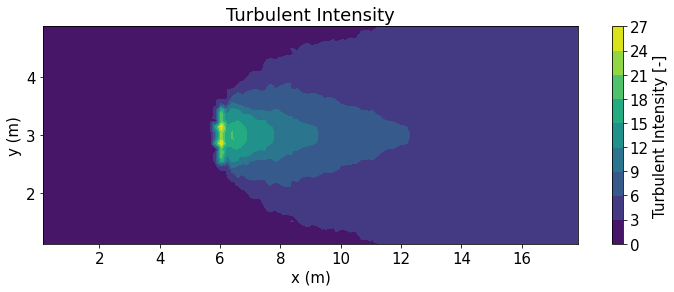

In [12]:
# Calculating turbulent intensity 
TI= d3d.turbulent_intensity(d3d_data, points= contour_points ,intermediate_values = True) 

# Creating new plot limits 
max_plot_v= 27
min_plot_v=0

# Plotting 
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(TI.x, TI.y, TI.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Turbulent Intensity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Turbulent Intensity [%]')

TI

## Comparing Face Data to Cell Data 
In Delft3D there is a staggered grid where some variables are stored on the faces and some are stored on the cells. The `d3d.variable_interpolation` function allows you to interpolate face data onto the cell locations or vice versa. For this example, we input the variable names, `'ucx'`, `'ucy'`,`'ucz'`, and `'turkin1'`, which are pulled from the NetCDF object (`d3d_data`) and are to be interpolated on to the coordinate system `'faces'`. The output is a data frame, `Var`, with the interpolated data. 

Near the boundaries linear linterpolate will sometimes return negative values. When calculating turbulent intensity negative turbulent kinetic energy values (`turkin1`) will have and invalid answered. To filter out any negative values the index of where the negative numbers are located are calculated as `neg_index`. If the value is close to 0 (greater then -1.0e-4) the values is replaced with zero, if not it is replaced with nan. `zero_bool` determines if the negative number is close to 0. `zero_ind` is the location of the negative numbers to be replaced with zero and `non_zero_bool` are the locations of the numbers to replace with nan. To calculate turbulent intensity the magnitude of the velocity is calculated with `'ucx'`, `'ucy'`, `'ucz'` and saved as `u_mag`.Turbulent intensity is then calculated with `u_mag` and `turkin1` and saved as `turbulent_intensity`. 

The data can be called, as shown, with `Var`.  We now have `'ucx'` and  `'turkin1'` on the same grid so then can be compared and used in calculations. 

In [13]:
variables= ['turkin1', 'ucx', 'ucy', 'ucz']

Var= d3d.variable_interpolation(d3d_data, variables, points= 'faces')

# Replacing negative numbers close to zero with zero
neg_index=np.where(Var['turkin1']<0)# Finding negative numbers

# Determining if negative number are close to zero 
zero_bool= np.isclose(Var['turkin1'][Var['turkin1']<0].array, 
                      np.zeros(len(Var['turkin1'][Var['turkin1']<0].array)),atol=1.0e-4)

# Identifying the location of negative values close to zero 
zero_ind= neg_index[0][zero_bool] 

# Identifying the location of negative number that are not close to zero
non_zero_ind= neg_index[0][~zero_bool]

# Replacing negative number close to zero with zero 
Var.loc[zero_ind,'turkin1']=np.zeros(len(zero_ind)) 

# Replacing negative numbers not close to zero with nan 
Var.loc[non_zero_ind,'turkin1']=[np.nan]*len(non_zero_ind)

# Calculating the root mean squared velocity 
Var['u_mag']=d3d.unorm(np.array(Var['ucx']),np.array(Var['ucy']), np.array(Var['ucz']))

# Calculating turbulent intensity as a percent 
Var['turbulent_intensity']= (np.sqrt(2/3*Var['turkin1'])/Var['u_mag'])*100 

Var

,x,y,z,turkin1,ucx,ucy,ucz,u_mag,turbulent_intensity
0,0.125,1.125,0.204638,0.009891,0.717881,-1.531373e-07,0.056840,0.720128,11.275974
1,0.375,1.125,0.199927,0.008654,0.689645,-3.833700e-07,-0.011832,0.689746,11.012108
2,0.125,1.375,0.204638,0.009891,0.717881,-4.313024e-07,0.056840,0.720128,11.275975
3,0.625,1.125,0.199497,0.008891,0.694164,-6.750081e-07,0.004593,0.694179,11.090669
4,0.375,1.375,0.199927,0.008654,0.689645,-1.064686e-06,-0.011832,0.689746,11.012109
...,...,...,...,...,...,...,...,...,...
5755,17.625,4.625,1.800595,0.000936,1.245117,9.389975e-04,0.033098,1.245558,2.005294
5756,17.375,4.875,1.800572,0.000916,1.222989,2.199022e-04,0.000277,1.222989,2.020447
5757,17.875,4.625,1.800020,0.000910,1.255866,8.894604e-04,0.010782,1.255913,1.961283
5758,17.625,4.875,1.800596,0.000916,1.245292,2.690449e-04,0.033248,1.245736,1.983439


When plotting data using `d3d.variable_interpolation`it is helpful to define points to interpolate onto as the `'cell'` and `'face'` grids contain a 3 dimensional grid of points. In this next example we will use the `d3d.variable_interpolation` function to plot a contour plot of tubulent intesity normal to turbine (y-z cross section) `n` turbine diameters downstream of the turbine.

As stated in the intro, the turbine is located at 6m along the length `turbine_x_loc` with a diameter of 0.7m  (`turbine_diameter`). Similar to the previous example, we input the variable names `variables` `'ucx'`, `'ucy'`,`'ucz'`, and `'turkin1'`, which are pulled from the NetCDF object (`d3d_data`). Unlike the previous example, the points are defined as `sample_points` created using `create_points` from `x_sample`, `y_sample`, and `z_sample` with `x_sample` at a constant point of 1 (`N`) turbine diameters downstream of the turbine (6.7m) and `y_sample` and `z_sample` being arrays between the minimum and maximum values for that flume dimension. The interpolated data is the saved from `d3d.variable_interpolation` as `Var_sample`and used to calculate turbulent intensity as in the previous example. The data is then plotted along the y and z axis.

[0, 1, 2]
points provided


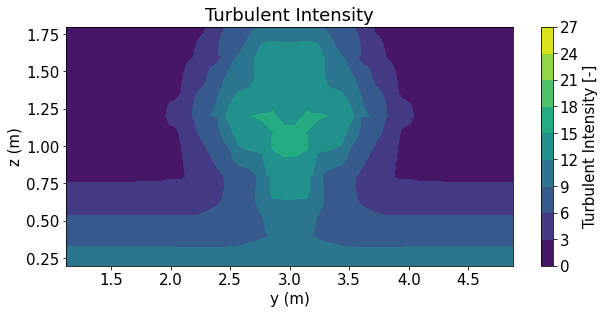

In [15]:
turbine_x_loc= 6 
turbine_diameter= 0.7
N=1
x_sample = turbine_x_loc+N*turbine_diameter
y_samples = np.linspace(ymin, ymax, num=40)
z_samples = np.linspace(zmin,zmax, num=256)

variables= ['turkin1', 'ucx', 'ucy', 'ucz']
sample_points = d3d.create_points(x_sample, y_samples, z_samples) 

Var_sample= d3d.variable_interpolation(d3d_data, variables, points= sample_points)

Var_sample['u_mag']=d3d.unorm(np.array(Var_sample['ucx']),np.array(Var_sample['ucy']), np.array(Var_sample['ucz'])) #root mean squared calculation 
Var_sample['turbulent_intensity']= np.sqrt(2/3*Var_sample['turkin1'])/Var_sample['u_mag']*100 # turbulent intesity calculation 

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tricontourf(Var_sample.y, Var_sample.z, Var_sample.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.title('Turbulent Intensity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Turbulent Intensity [%]')

This sample data used in this example is not spatial or temporally resolved and is for demonstration purposes only. In this example there are 5 sigma layers. The low level of discretization can be seen in in the sharp edges in the turbulent intensity plot above around the turbine.